Start here to begin with Stingray.

In [1]:
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Creating a light curve

In [2]:
from stingray import Lightcurve

A `Lightcurve` object is usually created in one of the following two ways:

1. From an array of time stamps and an array of counts.
        
        lc = Lightcurve(times, counts, **opts)

    where `**opts` are any (optional) keyword arguments (e.g. `dt=0.1`, `mjdref=55000`, etc.)

2. From photon arrival times.

        lc = Lightcurve.make_lightcurve(event_arrival_times, dt=1, **opts)

as will be described in the next sections.

An additional possibility is creating an empty `Lightcurve` object, whose attributes will be filled in later:

    lc = Lightcurve()

or, if one wants to specify any keyword arguments:

    lc = Lightcurve(**opts)

 This option is usually only relevant to advanced users, but we mention it here for reference

## 1. Array of time stamps and counts

Create 1000 time stamps

In [3]:
times = np.arange(1000)
times[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Create 1000 random Poisson-distributed counts:

In [4]:
counts = np.random.poisson(100, size=len(times))
counts[:10]

array([ 91,  98,  98,  98, 108,  86, 101, 114,  93,  95])

Create a Lightcurve object with the times and counts array.

In [5]:
lc = Lightcurve(times, counts)

The number of data points can be counted with the `len` function.

In [6]:
len(lc)

1000

Note the warnings thrown by the syntax above. By default, `stingray` does a number of checks on the data that is put into the `Lightcurve` class. For example, it checks whether it's evenly sampled. It also computes the time resolution `dt`. All of these checks take time. If you know the time resolution, it's a good idea to put it in manually. If you know that your light curve is well-behaved (for example, because you know the data really well, or because you've generated it yourself, as we've done above), you can skip those checks and save a bit of time:

In [7]:
dt = 1 
lc = Lightcurve(times, counts, dt=dt, skip_checks=True)

## 2. Photon Arrival Times

Often, you might have unbinned photon arrival times, rather than a light curve with time stamps and associated measurements. If this is the case, you can use the `make_lightcurve` method to turn these photon arrival times into a regularly binned light curve.

In [8]:
arrivals = np.loadtxt("photon_arrivals.txt")
arrivals[:10]

array([1., 1., 2., 2., 2., 3., 3., 3., 3., 3.])

In [9]:
lc_new = Lightcurve.make_lightcurve(arrivals, dt=1)

The time bins and respective counts can be seen with `lc.counts` and `lc.time`

In [10]:
lc_new.counts

array([2, 3, 5, 1, 4, 1, 3, 1, 1])

In [11]:
lc_new.time

array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

One useful feature is that you can explicitly pass in the start time and the duration of the observation. This can be helpful because the chance that a photon will arrive exactly at the start of the observation and the end of the observation is very small. In practice, when making multiple light curves from the same observation (e.g. individual light curves of multiple detectors, of for different energy ranges) this can lead to the creation of light curves with time bins that are *slightly* offset from one another. Here, passing in the total duration of the observation and the start time can be helpful.

In [12]:
lc_new = Lightcurve.make_lightcurve(arrivals, dt=1.0, tstart=1.0, tseg=9.0)

# Properties

A Lightcurve object has the following properties :

1. `time` : numpy array of time values
2. `counts` : numpy array of counts per bin values
3. `counts_err`: numpy array with the uncertainties on the values in `counts`
4. `countrate` : numpy array of counts per second
5. `countrate_err`: numpy array of the uncertainties on the values in `countrate`
4. `n` : Number of data points in the lightcurve
5. `dt` : Time resolution of the light curve
6. `tseg` : Total duration of the light curve
7. `tstart` : Start time of the light curve
8. `meancounts`: The mean counts of the light curve
9. `meanrate`: The mean count rate of the light curve
10. `mjdref`: MJD reference date (``tstart`` / 86400 gives the date in MJD at the start of the observation)
11. `gti`:Good Time Intervals. They indicate the "safe" time intervals to be used during the analysis of the light curve. 
12. `err_dist`: Statistic of the Lightcurve, it is used to calculate the uncertainties and other statistical values appropriately. It propagates to Spectrum classes


In [13]:
lc.n == len(lc)

True

Note that by default, `stingray` assumes that the user is passing a light curve in **counts per bin**. That is, the counts in bin $i$ will be the number of photons that arrived in the interval $t_i - 0.5\Delta t$ and $t_i + 0.5\Delta t$. Sometimes, data is given in **count rate**, i.e. the number of events that arrive within an interval of a *second*. The two will only be the same if the time resolution of the light curve is exactly 1 second.

Whether the input data is in counts per bin or in count rate can be toggled via the boolean `input_counts` keyword argument. By default, this argument is set to `True`, and the code assumes the light curve passed into the object is in counts/bin. By setting it to `False`, the user can pass in count rates:

In [14]:
# times with a resolution of 0.1
dt = 0.1
times = np.arange(0, 100, dt)
times[:10]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [15]:
mean_countrate = 100.0
countrate = np.random.poisson(mean_countrate, size=len(times))

In [16]:
lc = Lightcurve(times, counts=countrate, dt=dt, skip_checks=True, input_counts=False)

Internally, both `counts` and `countrate` attribute will be defined no matter what the user passes in, since they're trivially converted between each other through a multiplication/division with `dt:

In [17]:
print(mean_countrate)
print(lc.countrate[:10])

100.0
[113  92 110  97 101 102 103 101 124  89]


In [18]:
mean_counts = mean_countrate * dt
print(mean_counts)
print(lc.counts[:10])

10.0
[11.3  9.2 11.   9.7 10.1 10.2 10.3 10.1 12.4  8.9]


## Error Distributions in `stingray.Lightcurve`

The instruments that record our data impose measurement noise on our measurements. Depending on the type of instrument, the statistical distribution of that noise can be different. `stingray` was originally developed with X-ray data in mind, where most data comes in the form of _photon arrival times_, which generate measurements distributed according to a Poisson distribution. By default, `err_dist` is assumed to Poisson, and this is the only statistical distribution currently fully supported. But you *can* put in your own errors (via `counts_err` or `countrate_err`). It'll produce a warning, and be aware that some of the statistical assumptions made about downstream products (e.g. the normalization of periodograms) may not be correct:

In [19]:
times = np.arange(1000)

mean_flux = 100.0 # mean flux
std_flux = 2.0 # standard deviation on the flux

# generate fluxes with a Gaussian distribution and 
# an array of associated uncertainties
flux = np.random.normal(loc=mean_flux, scale=std_flux, size=len(times)) 
flux_err = np.ones_like(flux) * std_flux

In [20]:
lc = Lightcurve(times, flux, err=flux_err, err_dist="gauss", dt=1.0, skip_checks=True)

## Good Time Intervals

`Lightcurve` (and most other core `stingray` classes) support the use of *Good Time Intervals* (or GTIs), which denote the parts of an observation that are reliable for scientific purposes. Often, GTIs introduce gaps (e.g. where the instrument was off, or affected by solar flares). By default. GTIs are passed and don't apply to the data within a `Lightcurve` object, but become relevant in a number of circumstances, such as when generating `Powerspectrum` objects. 

If no GTIs are given at instantiation of the `Lightcurve` class, an artificial GTI will be created spanning the entire length of the data set being passed in:

In [21]:
times = np.arange(1000)
counts = np.random.poisson(100, size=len(times))

lc = Lightcurve(times, counts, dt=1, skip_checks=True)

In [22]:
lc.gti

array([[-5.000e-01,  9.995e+02]])

In [23]:
print(times[0]) # first time stamp in the light curve
print(times[-1]) # last time stamp in the light curve
print(lc.gti) # the GTIs generated within Lightcurve

0
999
[[-5.000e-01  9.995e+02]]


In [24]:
gti = [(0, 500), (600, 1000)]

In [25]:
lc = Lightcurve(times, counts, dt=1, skip_checks=True, gti=gti)

In [26]:
print(lc.gti)

[[   0  500]
 [ 600 1000]]


We'll get back to these when we talk more about some of the methods that apply GTIs to the data.

# Operations

## Addition/Subtraction

Two light curves can be summed up or subtracted from each other if they have same time arrays.

In [27]:
lc = Lightcurve(times, counts, dt=1, skip_checks=True)
lc_rand = Lightcurve(np.arange(1000), [500]*1000, dt=1, skip_checks=True)

In [28]:
lc_sum = lc + lc_rand

In [29]:
print("Counts in light curve 1: " + str(lc.counts[:5]))
print("Counts in light curve 2: " + str(lc_rand.counts[:5]))
print("Counts in summed light curve: " + str(lc_sum.counts[:5]))

Counts in light curve 1: [103  99 102 109 104]
Counts in light curve 2: [500 500 500 500 500]
Counts in summed light curve: [603 599 602 609 604]


## Negation

A negation operation on the lightcurve object inverts the count array from positive to negative values.

In [30]:
lc_neg = -lc

In [31]:
lc_sum = lc + lc_neg

In [32]:
np.all(lc_sum.counts == 0)  # All the points on lc and lc_neg cancel each other

True

## Indexing

Count value at a particular time can be obtained using indexing.

In [33]:
lc[120]

113

A Lightcurve can also be sliced to generate a new object.

In [34]:
lc_sliced = lc[100:200]

In [35]:
len(lc_sliced.counts)

100

# Methods

## Concatenation

Two light curves can be combined into a single object using the `join` method. Note that both of them must not have overlapping time arrays.

In [36]:
lc_1 = lc

In [37]:
lc_2 = Lightcurve(np.arange(1000, 2000), np.random.rand(1000)*1000, dt=1, skip_checks=True)

In [38]:
lc_long = lc_1.join(lc_2, skip_checks=True)  # Or vice-versa

In [39]:
print(len(lc_long))

2000


## Truncation

A light curve can also be truncated.

In [40]:
lc_cut = lc_long.truncate(start=0, stop=1000)

In [41]:
len(lc_cut)

1000

**Note** : By default, the `start` and `stop` parameters are assumed to be given as **indices** of the time array. However, the `start` and `stop` values can also be given as time values in the same value as the time array.

In [42]:
lc_cut = lc_long.truncate(start=500, stop=1500, method='time')

In [43]:
lc_cut.time[0], lc_cut.time[-1]

(500, 1499)

## Re-binning

The time resolution (`dt`) can also be changed to a larger value.

**Note** : While the new resolution need not be an integer multiple of the previous time resolution, be aware that if it is not, the last bin will be cut off by the fraction left over by the integer division.

In [44]:
lc_rebinned = lc_long.rebin(2)

In [45]:
print("Old time resolution = " + str(lc_long.dt))
print("Number of data points = " + str(lc_long.n))
print("New time resolution = " + str(lc_rebinned.dt))
print("Number of data points = " + str(lc_rebinned.n))

Old time resolution = 1
Number of data points = 2000
New time resolution = 2
Number of data points = 1000


## Sorting

A lightcurve can be sorted using the `sort` method. This function sorts `time` array and the `counts` array is changed accordingly.

In [46]:
new_lc_long = lc_long[:]  # Copying into a new object

In [47]:
new_lc_long = new_lc_long.sort(reverse=True)

In [48]:
new_lc_long.time[0] == max(lc_long.time)

True

You can sort by the `counts` array using `sort_counts` method which changes `time` array accordingly:

In [49]:
new_lc = lc_long[:]
new_lc = new_lc.sort_counts()
new_lc.counts[-1] == max(lc_long.counts)

True

## Plotting

A curve can be plotted with the `plot` method.

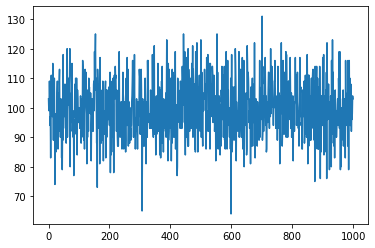

In [50]:
lc.plot()

A plot can also be customized using several keyword arguments.

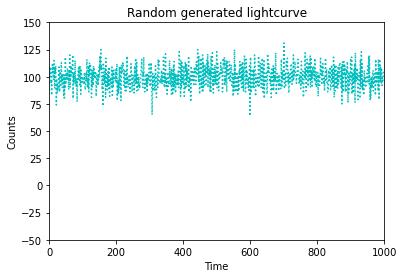

In [51]:
lc.plot(labels=('Time', "Counts"),  # (xlabel, ylabel)
        axis=(0, 1000, -50, 150),  # (xmin, xmax, ymin, ymax)
        title="Random generated lightcurve",
        marker='c:')  # c is for cyan and : is the marker style

The figure drawn can also be saved in a file using keywords arguments in the plot method itself.

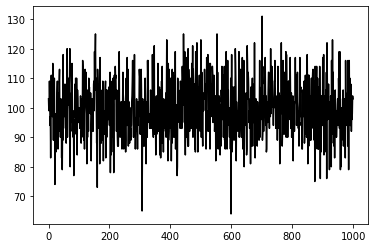

In [52]:
lc.plot(marker = 'k', save=True, filename="lightcurve.png")

**Note** : See `utils.savefig` function for more options on saving a file.

# Sample Data

Stingray also has a sample `Lightcurve` data which can be imported from within the library.

In [53]:
from stingray import sampledata

In [54]:
lc = sampledata.sample_data()

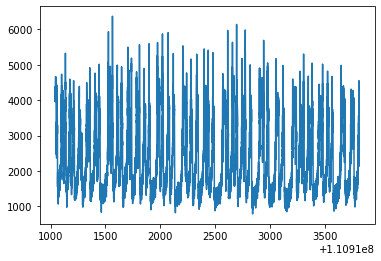

In [55]:
lc.plot()

## Checking the Light Curve for Irregularities

You can perform checks on the behaviour of the light curve, similar to what's done when instantiating a `Lightcurve` object when `skip_checks=False`, by calling the relevant method:

In [56]:
time = np.hstack([np.arange(0, 10, 0.1), np.arange(10, 20, 0.3)]) # uneven time resolution
counts = np.random.poisson(100, size=len(time))

lc = Lightcurve(time, counts, dt=1.0, skip_checks=True)

In [57]:
lc.check_lightcurve()

Let's add some badly formatted GTIs:

In [58]:
gti = [(10, 100, 123), (20, 30, 40)] # not a well-behaved GTI
lc = Lightcurve(time, counts, dt=0.1, skip_checks=True, gti=gti)

In [59]:
# This will fail
lc.check_lightcurve()

TypeError: Please check formatting of GTIs. They need to be provided as [[gti00, gti01], [gti10, gti11], ...]

## MJDREF and Shifting Times

The `mjdref` keyword argument defines a reference time in Modified Julian Date. Often, X-ray missions count their internal time in seconds from a given reference date and time (so that numbers don't become arbitrarily large). The data is then in the format of Mission Elapsed Time (MET), or seconds since that reference time. 

`mjdref` is generally passed into the `Lightcurve` object at instantiation, but it can be changed later:

In [60]:
mjdref = 91254
time = np.arange(1000)
counts = np.random.poisson(100, size=len(time))

lc = Lightcurve(time, counts, dt=1, skip_checks=True, mjdref=mjdref)
print(lc.mjdref)

91254


In [61]:
mjdref_new = 91254 + 20
lc_new = lc.change_mjdref(mjdref_new)
print(lc_new.mjdref)

91274


This change only affects the *reference time*, not the values given in the `time` attribute. However, it is also possible to shift the *entire light curve*, along with its GTIs:

In [62]:
gti = [(0,500), (600, 1000)]
lc.gti = gti

In [63]:
print("first three time bins: " + str(lc.time[:3]))
print("GTIs: " + str(lc.gti))

first three time bins: [0 1 2]
GTIs: [[   0  500]
 [ 600 1000]]


In [64]:
time_shift = 10.0
lc_shifted = lc.shift(time_shift)

In [65]:
print("Shifted first three time bins: " + str(lc_shifted.time[:3]))
print("Shifted GTIs: " + str(lc_shifted.gti))

Shifted first three time bins: [10. 11. 12.]
Shifted GTIs: [[  10.  510.]
 [ 610. 1010.]]


## Calculating a baseline

**TODO**: Need to document this method

## Working with GTIs and Splitting Light Curves

It is possible to split light curves into multiple segments. In particular, it can be useful to split light curves with large gaps into individual contiguous segments without gaps. 

In [66]:
# make a time array with a big gap and a small gap
time = np.array([1, 2, 3, 10, 11, 12, 13, 14, 17, 18, 19, 20])
counts = np.random.poisson(100, size=len(time))

lc = Lightcurve(time, counts, skip_checks=True)

In [67]:
lc.gti

array([[ 0.5, 20.5]])

This light curve has uneven bins. It has a large gap between 3 and 10, and a smaller gap between 14 and 17. We can use the `split` method to split it into three contiguous segments:

In [68]:
lc_split = lc.split(min_gap=2*lc.dt)

In [69]:
for lc_tmp in lc_split:
    print(lc_tmp.time)

[1 2 3]
[10 11 12 13 14]
[17 18 19 20]


This has split the light curve into three contiguous segments. You can adjust the tolerance for the size of gap that's acceptable via the `min_gap` attribute. You can also require a minimum number of data points in the output light curves. This is helpful when you're only interested in contiguous segments of a certain length:

In [70]:
lc_split = lc.split(min_gap=6.0)

In [71]:
for lc_tmp in lc_split:
    print(lc_tmp.time)

[1 2 3]
[10 11 12 13 14 17 18 19 20]


What if we only want the long segment?

In [72]:
lc_split = lc.split(min_gap=6.0, min_points=4)

In [73]:
for lc_tmp in lc_split:
    print(lc_tmp.time)

[10 11 12 13 14 17 18 19 20]


A special case of splitting your light curve object is to split by GTIs. This can be helpful if you want to look at individual contiguous segments separately:

In [74]:
# make a time array with a big gap and a small gap
time = np.arange(20)
counts = np.random.poisson(100, size=len(time))
gti = [(0,8), (12,20)]


lc = Lightcurve(time, counts, dt=1, skip_checks=True, gti=gti)

In [75]:
lc_split = lc.split_by_gti()

In [76]:
for lc_tmp in lc_split:
    print(lc_tmp.time)

[1 2 3 4 5 6 7]
[13 14 15 16 17 18 19]


Because I'd passed in GTIs that define the range from 0-8 and from 12-20 as good time intervals, the light curve will be split into two individual ones containing all data points falling within these ranges.

You can also apply the GTIs *directly* to the original light curve, which will filter `time`, `counts`, `countrate`, `counts_err` and `countrate_err` to only fall within the bounds of the GTIs:

In [77]:
# make a time array with a big gap and a small gap
time = np.arange(20)
counts = np.random.poisson(100, size=len(time))
gti = [(0,8), (12,20)]


lc = Lightcurve(time, counts, dt=1, skip_checks=True, gti=gti)

**Caution**: This is one of the few methods that change the original state of the object, rather than returning a new copy of it with the changes applied! So any events falling outside of the range of the GTIs will be lost:

In [78]:
# time array before applying GTIs:
lc.time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [79]:
lc.apply_gtis()

In [80]:
# time array after applying GTIs
lc.time

array([ 1,  2,  3,  4,  5,  6,  7, 13, 14, 15, 16, 17, 18, 19])

As you can see, the time bins 8-12 have been dropped, since they fall outside of the GTIs. 

## Analyzing Light Curve Segments

There's some functionality in `stingray` aimed at making analysis of individual light curve segments (or chunks, as they're called throughout the code) efficient. 

One helpful function tells you the length that segments should have to satisfy two conditions: (1) the minimum number of time bins in the segment, and (2) the minimum total number of counts (or flux) in each segment.

Let's give this a try with an example:

In [81]:
dt=1.0
time = np.arange(0, 100, dt)
counts = np.random.poisson(100, size=len(time))

lc = Lightcurve(time, counts, dt=dt, skip_checks=True)


In [82]:
min_total_counts = 300
min_total_bins = 2
estimated_chunk_length = lc.estimate_chunk_length(min_total_counts, min_total_bins)

print("The estimated length of each segment in seconds to satisfy both conditions is: " + str(estimated_chunk_length))

The estimated length of each segment in seconds to satisfy both conditions is: 4.0


So we have time bins of 1 second time resolution, each with an average of 100 counts/bin. We require at least 2 time bins in each segment, and also a minimum number of total counts in the segment of 300. In theory, you'd expect to need 3 time bins (so 3-second segments) to satisfy the condition above. However, the Poisson distribution is quite variable, so we cannot guarantee that all bins will have a total number of counts above 300. Hence, our segments need to be 4 seconds long. 

We can now use these segments to do some analysis, using the `analyze_by_chunks` method. In the simplest, case we can use a standard `numpy` operation to learn something about the properties of each segment:

In [83]:
start_times, stop_times, lc_sums = lc.analyze_lc_chunks(segment_size = 10.0, func=np.median)

In [84]:
lc_sums

array([102. , 110. ,  92. ,  96.5,  99.5, 100. ,  95. ,  96.5, 100. ,
       108. ])

This splits the light curve into 10-second segments, and then finds the median number of counts/bin in each segment. For a flat light curve like the one we generated above, this isn't super interesting, but this method can be helpful for more complex analyses. Instead of `np.median`, you can also pass in your own function:

In [85]:
def myfunc(lc):
    """
    Not a very interesting function
    """
    return np.sum(lc.counts) * 10.0

In [86]:
start_times, stop_times, lc_result = lc.analyze_lc_chunks(segment_size=10.0, func=myfunc)

In [87]:
lc_result

array([10090., 10830.,  9370., 10120., 10180., 10190.,  9910.,  9610.,
        9880., 10600.])

## Compatibility with `Lightkurve`

The [`Lightkurve` package](https://lightkurve.github.io/lightkurve/) provides a large amount of complementary functionality to stingray, in particular for data observed with Kepler and TESS, stars and exoplanets, and unevenly sampled data. We have implemented a conversion method that converts to/from `stingray`'s native `Lightcurve` object and `Lightkurve`'s native `LightCurve` object. Equivalent functionality exists in `Lightkurve`, too. The users who have not installed Lightkurve package should do so first by running *pip install lightkurve* in their terminal and then following with the next command.

In [88]:
import lightkurve

In [89]:
lc_new = lc.to_lightkurve()

In [90]:
type(lc_new)

lightkurve.lightcurve.LightCurve

In [91]:
lc_new.time

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [92]:
lc_new.flux

array([110,  82,  94, 126, 102,  80, 102, 105, 106, 102, 119,  98, 112,
        98, 119, 112, 119,  99,  99, 108,  91,  85,  93, 109,  97,  82,
        87,  89,  96, 108, 120,  88,  97,  88, 109, 120,  94, 106,  94,
        96, 120, 122,  92,  87, 113,  94, 100,  99, 105,  86, 107, 101,
        94, 102,  96, 112,  93, 117,  99,  98,  91, 101,  94, 120, 105,
        91,  91,  96,  85, 117, 104, 102,  91,  94, 100, 115,  98,  74,
        95,  88, 100, 107, 102, 109, 109,  94,  86,  84,  97, 100, 110,
       109, 117,  96, 108, 108, 110, 108,  97,  97])

Let's do the rountrip to stingray:

In [93]:
lc_back = lc_new.to_stingray()

In [94]:
lc_back.time

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [95]:
lc_back.counts

array([110.,  82.,  94., 126., 102.,  80., 102., 105., 106., 102., 119.,
        98., 112.,  98., 119., 112., 119.,  99.,  99., 108.,  91.,  85.,
        93., 109.,  97.,  82.,  87.,  89.,  96., 108., 120.,  88.,  97.,
        88., 109., 120.,  94., 106.,  94.,  96., 120., 122.,  92.,  87.,
       113.,  94., 100.,  99., 105.,  86., 107., 101.,  94., 102.,  96.,
       112.,  93., 117.,  99.,  98.,  91., 101.,  94., 120., 105.,  91.,
        91.,  96.,  85., 117., 104., 102.,  91.,  94., 100., 115.,  98.,
        74.,  95.,  88., 100., 107., 102., 109., 109.,  94.,  86.,  84.,
        97., 100., 110., 109., 117.,  96., 108., 108., 110., 108.,  97.,
        97.])

Similarly, we can transform `Lightcurve` objects to and from `astropy.TimeSeries` objects:

In [96]:
dt=1.0
time = np.arange(0, 100, dt)
counts = np.random.poisson(100, size=len(time))

lc = Lightcurve(time, counts, dt=dt, skip_checks=True)

# convet to astropy.TimeSeries object
ts = lc.to_astropy_timeseries()

In [97]:
type(ts)

astropy.timeseries.sampled.TimeSeries

In [98]:
ts[:10]

time,counts
object,int64
0.0,100
1.1574074074074073e-05,92
2.3148148148148147e-05,98
3.472222222222222e-05,85
4.6296296296296294e-05,113
5.787037037037037e-05,94
6.944444444444444e-05,99
8.101851851851852e-05,108
9.259259259259259e-05,101


lc_back = Lightcurve.from_astropy_timeseries(ts)

## Reading/Writing Lightcurves to/from files

The `Lightcurve` class has some rudimentary reading/writing capabilities via the `read` and `write` methods. For more information `stingray` inputs and outputs, please refer to the I/O tutorial.